In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
import pandas as pd
from tqdm import auto
from visualization import pole_visualization, coeff_visualization, fn_visualization

In [2]:
from tphenotype import LaplaceEncoder
from tphenotype.utils import data_split
from tphenotype.baselines.s2s import S2S

In [3]:
os.makedirs("figures", exist_ok=True)

In [4]:
# Four types of curves


def func1(t):
    v = np.cos(2 * np.pi * t)
    return v


def func2(t):
    v = np.cos(np.pi * t)
    return v


def func3(t):
    v = np.sin(np.pi * t)
    return v


def func4(t):
    v = np.sin(2 * np.pi * t)
    return v

In [5]:
def gen_data(seed=0):
    # generate samples with noises
    T = 15
    n = 1000
    rng = np.random.default_rng(seed=seed)

    # irregular sampling interval
    alpha = 3 * np.ones(T)
    dt = rng.dirichlet(alpha, size=(n,))
    t = np.cumsum(dt, axis=1)

    phases = rng.exponential(scale=0.5, size=(n, 1))

    # generate curves with labels
    fn_type = np.zeros((n,))
    n1 = int(0.25 * n)
    n2 = n1 + int(0.25 * n)
    n3 = n2 + int(0.25 * n)
    n4 = n - n3

    t_d = t - phases
    f1 = func1(t_d[:n1])
    f2 = func2(t_d[n1:n2])
    f3 = func3(t_d[n2:n3])
    f4 = func4(t_d[n3:])
    fn_type[:n1] = 1
    fn_type[n1:n2] = 2
    fn_type[n2:n3] = 3
    fn_type[n3:] = 4

    # add noises
    f = np.concatenate([f1, f2, f3, f4], axis=0) + rng.normal(size=(n, T)) * 0.03

    # shuffle samples
    idx = np.arange(len(f))
    rng.shuffle(idx)
    f = f[idx]
    fn_type = fn_type[idx]
    t = t[idx]

    # generate masks for valid observations
    length = rng.integers(low=int(3 * T / 4), high=T, size=n)
    # only first l samples are valid
    mask = np.zeros_like(t, dtype=bool)
    # all samples are valid
    mask = np.ones_like(t, dtype=bool)
    for i in range(n):
        mask[i, : length[i]] = 1
    dataset = {
        "t": t,
        "f": f,
        "mask": mask,
        "fn_type": fn_type,
    }
    return dataset

### Comparison with Seq2Seq encoder

In [6]:
# model configuration
net_config = {
    "num_poles": 4,  # number of poles
    "max_degree": 1,  # maximum degree of poles
    "hidden_size": 10,  # number of hidden units in neural networks
    "num_layers": 1,  # number of layers in MLP of the encoder (1 layer RNN + n layer MLP)
    "pole_separation": 1.0,  # minimum distance between distinct poles
    "freq_scaler": 20,  # scale up the imaginary part to help learning
    "window_size": None,  # whether or not to include time delay terms
    "equivariant_embed": True,  # whether or not to sort the poles (useless during training)
    "device": "cpu",
}

loss_weights = {
    "rmse": 1.0,  # regression loss
    "mse": 1.0,
    "cont": 0.01,  # minimize used components
    "pole": 1.0,  # separation of poles
    "real": 0.1,  # only generate real function (penalty for imaginary part)
}

In [7]:
def benchmark_Laplace(net_config, loss_weights, n_trial=5, seed=0, epochs=50):
    mses = []
    for i in range(n_trial):
        # prepare training and validation sets
        dtype = "float32"
        dataset = gen_data(seed + i)

        train_set, test_set = data_split(dataset, test_size=0.2, random_state=seed, dtype=dtype)
        train_set, valid_set = data_split(train_set, test_size=0.2, random_state=seed, dtype=dtype)
        torch.manual_seed(seed + i)
        encoder = LaplaceEncoder(**net_config)
        encoder = encoder.fit(train_set, loss_weights, valid_set=valid_set, epochs=epochs)

        f = test_set["f"]
        t = test_set["t"]
        mask = test_set["mask"]
        poles, coeffs = encoder.encode(f, t)
        f_rec_r, f_rec_i = encoder.decode(poles, coeffs, t)  # (re, im)
        f_rec = f_rec_r + 1j * f_rec_i
        diff = np.square(np.abs(f - f_rec[:, -1]))
        mse = np.sum(diff * mask, axis=-1) / np.sum(mask, axis=-1)
        mse = np.mean(mse)
        mses.append(mse)
    return mses

In [ ]:
mses = benchmark_Laplace(net_config, loss_weights, n_trial=5)

In [9]:
mses

[0.039721943, 0.04589908, 0.041122235, 0.035403565, 0.033764865]

In [10]:
mean, std, ci = np.mean(mses), np.std(mses), np.std(mses) * 1.96
print(f"Laplace Encoder MSE: {mean:.4f}+-{ci:.4f}")

Laplace Encoder MSE: 0.0392+-0.0084


In [13]:
s2s_config = {"latent_size": 10, "hidden_size": 10, "num_layers": 1, "device": "cpu"}


def benchmark_S2S(s2s_config, n_trial=5, seed=0, epochs=50):
    mses = []
    for i in range(n_trial):
        # prepare training and validation sets
        dtype = "float32"
        dataset = gen_data(seed + i)

        train_set, test_set = data_split(dataset, test_size=0.2, random_state=seed, dtype=dtype)
        train_set, valid_set = data_split(train_set, test_size=0.2, random_state=seed, dtype=dtype)
        torch.manual_seed(seed + i)
        s2s = S2S(**s2s_config)
        s2s = s2s.fit(train_set, loss_weights, valid_set=valid_set, epochs=epochs)

        f = test_set["f"]
        t = test_set["t"]
        mask = test_set["mask"]
        z = s2s.encode(f, t)
        f_rec = s2s.decode(z, t)  # (re, im)
        diff = np.square(np.abs(f - f_rec))
        mse = np.sum(diff * mask, axis=-1) / np.sum(mask, axis=-1)
        mse = np.mean(mse)
        mses.append(mse)
    return mses

In [ ]:
mses = benchmark_S2S(s2s_config, n_trial=5)

In [15]:
mses

[0.098402284, 0.11342397, 0.11567722, 0.11828035, 0.09529116]

In [16]:
mean, std, ci = np.mean(mses), np.std(mses), np.std(mses) * 1.96
print(f"S2S MSE: {mean:.4f}+-{ci:.4f}")

S2S MSE: 0.1082+-0.0185


#### Example

In [17]:
# prepare training and validation sets
seed = 0
dtype = "float32"
dataset = gen_data(seed)

train_set, test_set = data_split(dataset, test_size=0.2, random_state=seed, dtype=dtype)
train_set, valid_set = data_split(train_set, test_size=0.2, random_state=seed, dtype=dtype)

In [ ]:
torch.manual_seed(seed)
s2s = S2S(**s2s_config)
s2s = s2s.fit(train_set, loss_weights, valid_set=valid_set, epochs=50)

In [ ]:
torch.manual_seed(seed)
encoder = LaplaceEncoder(**net_config)
encoder = encoder.fit(train_set, loss_weights, valid_set=valid_set, epochs=50)

In [20]:
f = test_set["f"]
t = test_set["t"]
mask = test_set["mask"]
fn_type = test_set["fn_type"]
poles, coeffs = encoder.encode(f, t)
f_rec = encoder.decode(poles, coeffs, t)  # (re, im)

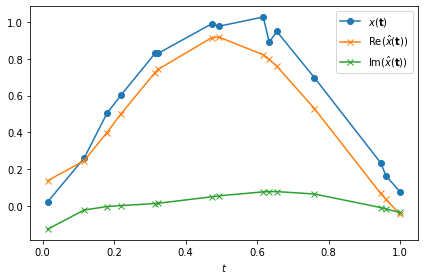

In [27]:
(idx,) = np.where(fn_type == 3)
fig = fn_visualization(t, f, f_rec, mask, idx[-1], window=30)
fig.savefig("figures/LaplaceEncoder.pdf")

In [28]:
z = s2s.encode(f, t)
f_rec1 = s2s.decode(z, t)

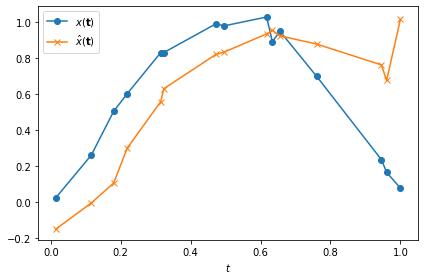

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
sel = idx[-1]
step = int(np.sum(mask[sel]) - 1)
ax.plot(t[sel, : step + 1], f[sel, : step + 1], label="$x(\mathbf{t})$", marker="o")
ax.plot(t[sel], f_rec1[sel, : step + 1], label="$\hat{x}(\mathbf{t})$", marker="x")
ymin, ymax = plt.ylim()
# ax.vlines(t[sel,step],ymin,ymax,color='red', linestyles='dashed')
ax.set_xlabel("$t$")

ax.legend()
fig.tight_layout()
fig.savefig("figures/AutoEncoder.pdf")

### Impact of pole_separation threshold $\delta$

In [ ]:
torch.manual_seed(seed)
net_config["pole_separation"] = 0.0
encoder = LaplaceEncoder(**net_config)
encoder = encoder.fit(train_set, loss_weights, valid_set=valid_set, epochs=50)

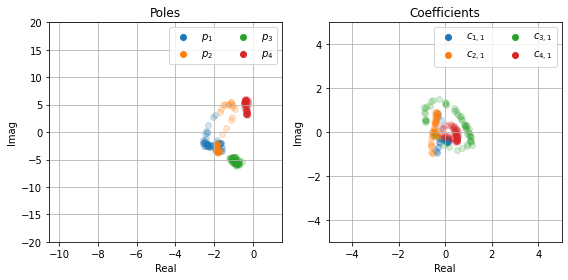

In [31]:
f = test_set["f"]
t = test_set["t"]
mask = test_set["mask"]
fn_type = test_set["fn_type"]
poles, coeffs = encoder.encode(f, t)
f_rec = encoder.decode(poles, coeffs, t)  # (re, im)
fn = 1
step = -1
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4 * 2, 4))
fig = pole_visualization(poles[fn_type == fn], step=step, ax=ax1)
fig = coeff_visualization(coeffs[fn_type == fn], degree=1, step=step, ax=ax2)
fig.savefig("figures/d_pole=0.0.pdf")

In [ ]:
torch.manual_seed(seed)
net_config["pole_separation"] = 1.0
encoder = LaplaceEncoder(**net_config)
encoder = encoder.fit(train_set, loss_weights, valid_set=valid_set, epochs=50)

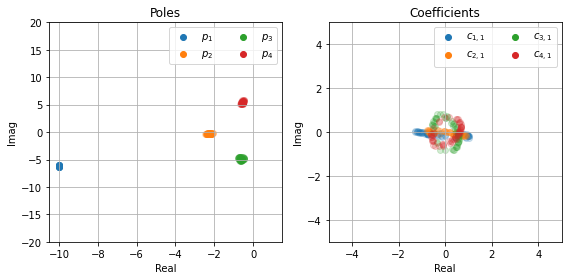

In [33]:
f = test_set["f"]
t = test_set["t"]
mask = test_set["mask"]
fn_type = test_set["fn_type"]
poles, coeffs = encoder.encode(f, t)
f_rec = encoder.decode(poles, coeffs, t)  # (re, im)
fn = 1
step = -1
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4 * 2, 4))
fig = pole_visualization(poles[fn_type == fn], step=step, ax=ax1)
fig = coeff_visualization(coeffs[fn_type == fn], degree=1, step=step, ax=ax2)
fig.savefig("figures/d_pole=1.0.pdf")

### Sensitivity Analysis

In [34]:
# model configuration
net_config = {
    "num_poles": 4,  # number of poles
    "max_degree": 1,  # maximum degree of poles
    "hidden_size": 10,  # number of hidden units in neural networks
    "num_layers": 1,  # number of layers in MLP of the encoder (1 layer RNN + n layer MLP)
    "pole_separation": 1.0,  # minimum distance between distinct poles
    "freq_scaler": 20,  # scale up the imaginary part to help learning
    "window_size": None,  # whether or not to include time delay terms
    "equivariant_embed": True,  # whether or not to sort the poles (useless during training)
    "device": "cpu",
}

loss_weights = {
    "rmse": 1.0,  # regression loss
    "mse": 1.0,
    "cont": 0.01,  #
    "pole": 1.0,  # separation of poles
    "real": 0.1,  # only generate real function (penalty for imaginary part)
}

In [35]:
def check_parameter_impact(net_config, loss_weights, param, values, n_trial=5, seed=0, epochs=50):
    net_config = net_config.copy()
    loss_weights = loss_weights.copy()
    df = pd.DataFrame()
    for val in auto.tqdm(values):
        if param in loss_weights:
            loss_weights[param] = val
        elif param in net_config:
            net_config[param] = val
        else:
            pass

        mses = []
        for i in range(n_trial):
            # prepare training and validation sets
            dtype = "float32"
            dataset = gen_data(seed + i)

            train_set, test_set = data_split(dataset, test_size=0.2, random_state=seed, dtype=dtype)
            train_set, valid_set = data_split(train_set, test_size=0.2, random_state=seed, dtype=dtype)
            torch.manual_seed(seed + i)
            encoder = LaplaceEncoder(**net_config)
            encoder = encoder.fit(
                train_set,
                loss_weights,
                valid_set=valid_set,
                epochs=epochs,
                verbose=False,
            )

            f = test_set["f"]
            t = test_set["t"]
            mask = test_set["mask"]
            poles, coeffs = encoder.encode(f, t)
            f_rec_r, f_rec_i = encoder.decode(poles, coeffs, t)  # (re, im)
            f_rec = f_rec_r + 1j * f_rec_i
            diff = np.square(np.abs(f - f_rec[:, -1]))
            mse = np.sum(diff * mask, axis=-1) / np.sum(mask, axis=-1)
            mse = np.mean(mse)
            mses.append(mse)
        mean, ci = np.mean(mses), np.std(mses) * 1.96
        df.loc[val, ["mean", "ci"]] = mean, ci
    return df

In [ ]:
param = "pole"
values = [0, 0.5, 1.0, 2.0, 10.0]
df_pole = check_parameter_impact(net_config, loss_weights, param, values, n_trial=3)

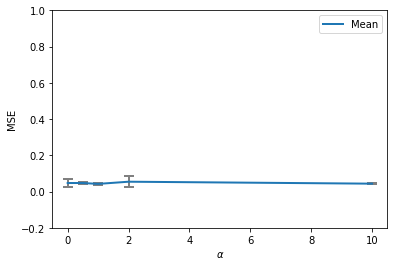

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
df_pole.plot(y="mean", yerr="ci", label="Mean", ax=ax, ecolor="gray", lw=2, capsize=5, capthick=2)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("MSE")
ax.set_ylim([-0.2, 1.0])
fig.savefig("figures/alpha_impact.pdf")

In [ ]:
param = "real"
values = [
    0,
    0.1,
    0.5,
    1.0,
]
df_real = check_parameter_impact(net_config, loss_weights, param, values, n_trial=3)

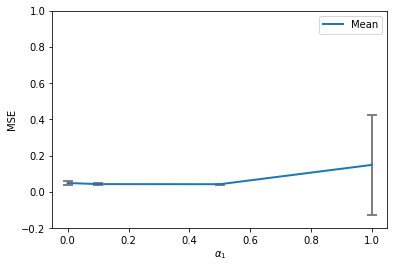

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
df_real.plot(y="mean", yerr="ci", label="Mean", ax=ax, ecolor="gray", lw=2, capsize=5, capthick=2)
ax.set_xlabel(r"$\alpha_1$")
ax.set_ylabel("MSE")
ax.set_ylim([-0.2, 1.0])
fig.savefig("figures/alpha_1_impact.pdf")

In [ ]:
param = "cont"
values = [0.01, 0.1, 1.0]
df_alpha_2 = check_parameter_impact(net_config, loss_weights, param, values, n_trial=3)

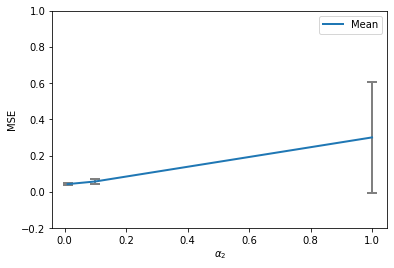

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
df_alpha_2.plot(y="mean", yerr="ci", label="Mean", ax=ax, ecolor="gray", lw=2, capsize=5, capthick=2)
ax.set_xlabel(r"$\alpha_2$")
ax.set_ylabel("MSE")
ax.set_ylim([-0.2, 1.0])
fig.savefig("figures/alpha_2_impact.pdf")

In [ ]:
param = "pole_separation"
values = [0.0, 1.0, 2.0, 10.0]
df_sep = check_parameter_impact(net_config, loss_weights, param, values, n_trial=3)

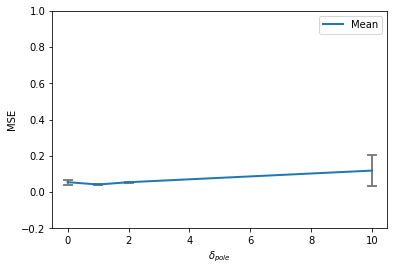

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))
df_sep.plot(y="mean", yerr="ci", label="Mean", ax=ax, ecolor="gray", lw=2, capsize=5, capthick=2)
ax.set_xlabel(r"$\delta_{pole}$")
ax.set_ylabel("MSE")
ax.set_ylim([-0.2, 1.0])
fig.savefig("figures/delta_pole_impact.pdf")

In [ ]:
param = "num_poles"
values = [2, 4, 8]
df_n = check_parameter_impact(net_config, loss_weights, param, values, n_trial=3)

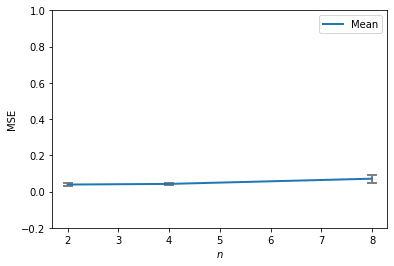

In [45]:
fig, ax = plt.subplots(figsize=(6, 4))
df_n.plot(y="mean", yerr="ci", label="Mean", ax=ax, ecolor="gray", lw=2, capsize=5, capthick=2)
ax.set_xlabel(r"$n$")
ax.set_ylabel("MSE")
ax.set_ylim([-0.2, 1.0])
fig.savefig("figures/n_impact.pdf")

In [ ]:
param = "max_degree"
values = [1, 2, 3]
df_d = check_parameter_impact(net_config, loss_weights, param, values, n_trial=3)

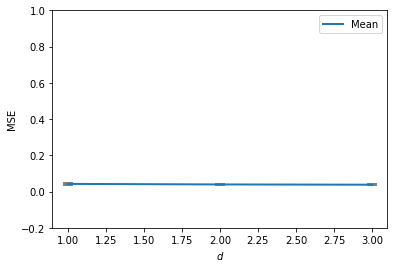

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))
df_d.plot(y="mean", yerr="ci", label="Mean", ax=ax, ecolor="gray", lw=2, capsize=5, capthick=2)
ax.set_xlabel(r"$d$")
ax.set_ylabel("MSE")
ax.set_ylim([-0.2, 1.0])
fig.savefig("figures/d_impact.pdf")